In [121]:
import pandas as pd
import numpy as np
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans
from env import get_db_url
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w
import explore as exp
from wrangle import clean_zillow
from wrangle import create_features
from wrangle import train_validate_test_split
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import model
from model import  select_kbest
# Vis imports to make things look pretty 
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.style as style 
style.available
style.use('seaborn-talk') #sets the size of the charts
style.use('seaborn-colorblind') #sets color of charts
from wrangle import wrangle_zillow


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Joseph Goerner 
## 06/20/2022

<img src="stampede.tif"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 20px;" />

 ______________
## <span style="color:maroon;"> In the Event of Clustering use the Elbow Method !!! </span>

Events in sequence 
1. Import 
2. Acquire Data
3. Clean, Prep and Split Data
4. Explore Data 
 * Hypothesis Testing
6. Evaluation of Data 
7. Modeling
 * Mvp, Identify Baseline 
 * Train and Validate 
 * We Test our best 
8. Conclusion and Recomindations 

In [2]:
df = w.zillow17()

In [3]:
df = w.wrangle_zillow()

In [4]:
def train_validate_test_split(df, target, seed):
    '''
    spilts our data  into train, validate, test
    '''
    # Train, Validate, and test
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed)
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed)
    # Split with X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test  

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 14297519 to 12826780
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   bathrooms               71818 non-null  float64 
 1   bedrooms                71818 non-null  int64   
 2   property_quality        71818 non-null  int64   
 3   sqft                    71818 non-null  float64 
 4   fips                    71818 non-null  int64   
 5   latitude                71818 non-null  float64 
 6   longitude               71818 non-null  float64 
 7   lot_sqft                71818 non-null  float64 
 8   rawcensustractandblock  71818 non-null  float64 
 9   regionidcity            71818 non-null  float64 
 10  zip_code                71818 non-null  int64   
 11  roomcnt                 71818 non-null  int64   
 12  unitcnt                 71818 non-null  int64   
 13  yearbuilt               71818 non-null  int64   
 14  structure_va

In [6]:
df.head().T

parcelid,14297519,17052889,14186244,12177905,10887214
bathrooms,3.5,1.0,2.0,3.0,3.0
bedrooms,4,2,3,4,3
property_quality,7,7,7,8,8
sqft,3100.0,1465.0,1243.0,2376.0,1312.0
fips,6059,6111,6059,6037,6037
latitude,33634931.0,34449266.0,33886168.0,34245180.0,34185120.0
longitude,-117869207.0,-119281531.0,-117823170.0,-118240722.0,-118414640.0
lot_sqft,4506.0,12647.0,8432.0,13038.0,278581.0
rawcensustractandblock,60590630.072012,61110010.023006,60590218.022012,60373001.001006,60371236.012
regionidcity,53571.0,13091.0,21412.0,396551.0,12447.0


In [7]:
dummies = pd.get_dummies(df.county) 
dummies.columns = ['LA', 'Orange', 'Ventura']
df = pd.concat([df, dummies], axis=1)

In [8]:
new = df[['LA', 'Orange', 'Ventura','fips','latitude', 'longitude', 'sqft', 'lot_sqft', 'zip_code', 'property_quality', 'home_age', 'logerror', 'structure_value', 'bedrooms' , 'bathrooms' , 'land_value']].copy()

In [9]:
new.head().T

parcelid,14297519,17052889,14186244,12177905,10887214
LA,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Orange,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
Ventura,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fips,6.059000e+03,6.111000e+03,6.059000e+03,6.037000e+03,6.037000e+03
latitude,3.363493e+07,3.444927e+07,3.388617e+07,3.424518e+07,3.418512e+07
longitude,-1.178692e+08,-1.192815e+08,-1.178232e+08,-1.182407e+08,-1.184146e+08
sqft,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,1.312000e+03
lot_sqft,4.506000e+03,1.264700e+04,8.432000e+03,1.303800e+04,2.785810e+05
zip_code,9.697800e+04,9.709900e+04,9.707800e+04,9.633000e+04,9.645100e+04
property_quality,7.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00,8.000000e+00


In [10]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test_split(new, 'logerror', 123)

In [11]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (40217, 16)
validate -> (17237, 16)
test -> (14364, 16)


In [12]:
train.head().T

parcelid,11736858,14279729,14748785,10796733,12102130
LA,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Orange,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
Ventura,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fips,6.037000e+03,6.059000e+03,6.059000e+03,6.037000e+03,6.037000e+03
latitude,3.403755e+07,3.362844e+07,3.342881e+07,3.417684e+07,3.413141e+07
longitude,-1.183548e+08,-1.179153e+08,-1.176279e+08,-1.185660e+08,-1.181319e+08
sqft,1.511000e+03,8.120000e+02,1.547000e+03,5.903000e+03,2.067000e+03
lot_sqft,5.291000e+03,7.920000e+03,7.265000e+03,2.199900e+04,9.960000e+03
zip_code,9.599700e+04,9.695900e+04,9.698200e+04,9.638900e+04,9.629400e+04
property_quality,6.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00


In [13]:
def Standard_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs
    """
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [14]:
train['structure_dollar_per_sqft'] = train.structure_value / train.sqft
train['land_dollar_per_sqft'] = train.land_value / train.lot_sqft
train['bed_bath_ratio'] = train.bedrooms / train.bathrooms

In [15]:
df['structure_dollar_per_sqft'] = df.structure_value / df.sqft
df['land_dollar_per_sqft'] = df.land_value / df.lot_sqft
df['bed_bath_ratio'] = df.bedrooms / df.bathrooms

In [16]:
new['structure_dollar_per_sqft'] = df.structure_value / df.sqft
new['land_dollar_per_sqft'] = df.land_value / df.lot_sqft
new['bed_bath_ratio'] = df.bedrooms / df.bathrooms

In [17]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Standard_Scaler(X_train, X_validate, X_test)

In [18]:
train.head().T

parcelid,11736858,14279729,14748785,10796733,12102130
LA,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Orange,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
Ventura,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fips,6.037000e+03,6.059000e+03,6.059000e+03,6.037000e+03,6.037000e+03
latitude,3.403755e+07,3.362844e+07,3.342881e+07,3.417684e+07,3.413141e+07
longitude,-1.183548e+08,-1.179153e+08,-1.176279e+08,-1.185660e+08,-1.181319e+08
sqft,1.511000e+03,8.120000e+02,1.547000e+03,5.903000e+03,2.067000e+03
lot_sqft,5.291000e+03,7.920000e+03,7.265000e+03,2.199900e+04,9.960000e+03
zip_code,9.599700e+04,9.695900e+04,9.698200e+04,9.638900e+04,9.629400e+04
property_quality,6.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00


In [19]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 14297519 to 12826780
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LA                         71818 non-null  uint8  
 1   Orange                     71818 non-null  uint8  
 2   Ventura                    71818 non-null  uint8  
 3   fips                       71818 non-null  int64  
 4   latitude                   71818 non-null  float64
 5   longitude                  71818 non-null  float64
 6   sqft                       71818 non-null  float64
 7   lot_sqft                   71818 non-null  float64
 8   zip_code                   71818 non-null  int64  
 9   property_quality           71818 non-null  int64  
 10  home_age                   71818 non-null  int64  
 11  logerror                   71818 non-null  float64
 12  structure_value            71818 non-null  float64
 13  bedrooms                   71818 non

In [20]:
new.columns

Index(['LA', 'Orange', 'Ventura', 'fips', 'latitude', 'longitude', 'sqft',
       'lot_sqft', 'zip_code', 'property_quality', 'home_age', 'logerror',
       'structure_value', 'bedrooms', 'bathrooms', 'land_value',
       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio'],
      dtype='object')

In [21]:
def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='maroon')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats

In [22]:
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)
        
def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        explore_bivariate_quant(train, target, quant)

def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue='target')
    plt.show()
    plot_all_continuous_vars(train, 'target', quant_vars)
    plt.show()    


In [23]:
binary_vars = ['LA', 'Orange', 'Ventura']
cat_vars = []
quant_var = ['fips', 'latitude', 'longitude', 'sqft',
       'lot_sqft', 'zip_code', 'property_quality', 'home_age','structure_value', 'bedrooms' , 'bathrooms' , 'land_value'
            ,'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio' ]
continuous_target = 'logerror'
categorical_target = 'logerror'

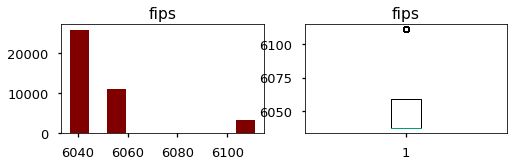

count    40217.000000
mean      6049.276351
std         21.040147
min       6037.000000
25%       6037.000000
50%       6037.000000
75%       6059.000000
max       6111.000000
Name: fips, dtype: float64


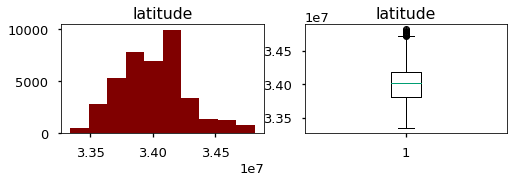

count    4.021700e+04
mean     3.400741e+07
std      2.671053e+05
min      3.333953e+07
25%      3.381196e+07
50%      3.402078e+07
75%      3.417650e+07
max      3.481877e+07
Name: latitude, dtype: float64


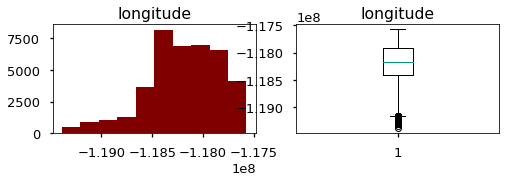

count    4.021700e+04
mean    -1.181994e+08
std      3.639335e+05
min     -1.193883e+08
25%     -1.184165e+08
50%     -1.181671e+08
75%     -1.179168e+08
max     -1.175728e+08
Name: longitude, dtype: float64


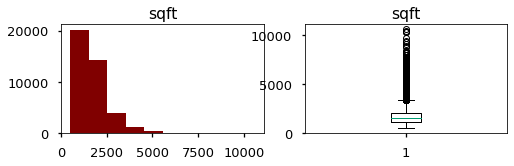

count    40217.000000
mean      1733.628714
std        861.174436
min        501.000000
25%       1171.000000
50%       1507.000000
75%       2044.000000
max      10605.000000
Name: sqft, dtype: float64


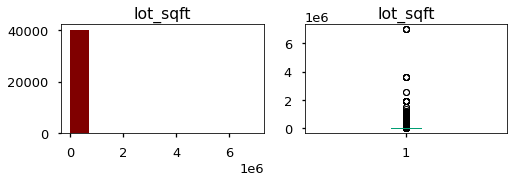

count    4.021700e+04
mean     2.816415e+04
std      1.253648e+05
min      2.360000e+02
25%      5.983000e+03
50%      7.265000e+03
75%      1.058800e+04
max      6.971010e+06
Name: lot_sqft, dtype: float64


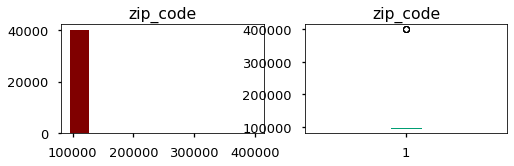

count     40217.000000
mean      96586.871298
std        3050.899556
min       95982.000000
25%       96208.000000
50%       96410.000000
75%       96989.000000
max      399675.000000
Name: zip_code, dtype: float64


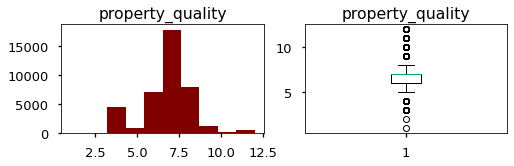

count    40217.000000
mean         6.753637
std          1.346508
min          1.000000
25%          6.000000
50%          7.000000
75%          7.000000
max         12.000000
Name: property_quality, dtype: float64


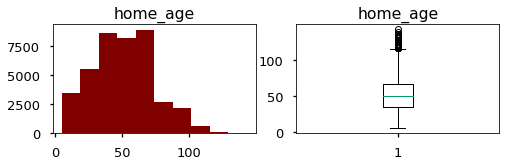

count    40217.000000
mean        51.419673
std         22.929058
min          5.000000
25%         34.000000
50%         50.000000
75%         67.000000
max        143.000000
Name: home_age, dtype: float64


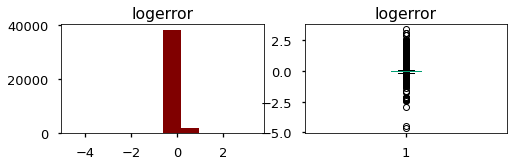

count    40217.000000
mean         0.015390
std          0.162298
min         -4.655420
25%         -0.023779
50%          0.006473
75%          0.037751
max          3.394544
Name: logerror, dtype: float64


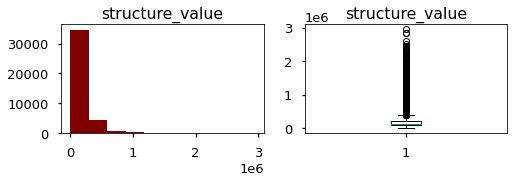

count    4.021700e+04
mean     1.813101e+05
std      1.783296e+05
min      1.480000e+02
25%      8.400000e+04
50%      1.347120e+05
75%      2.139880e+05
max      2.943209e+06
Name: structure_value, dtype: float64


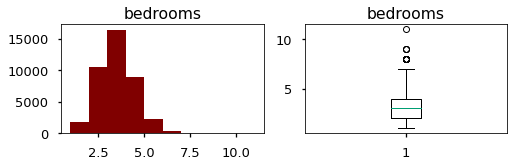

count    40217.000000
mean         3.008852
std          0.989914
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64


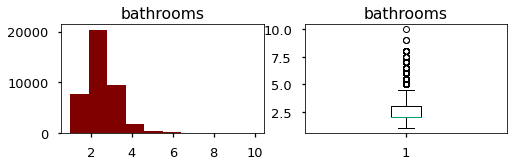

count    40217.000000
mean         2.269053
std          0.914743
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: bathrooms, dtype: float64


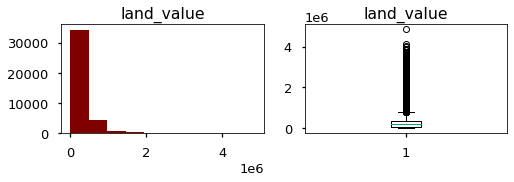

count    4.021700e+04
mean     2.837746e+05
std      3.265030e+05
min      1.196000e+03
25%      8.338700e+04
50%      2.030890e+05
75%      3.620000e+05
max      4.847224e+06
Name: land_value, dtype: float64


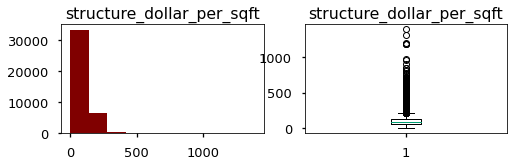

count    40217.000000
mean        99.532276
std         59.399594
min          0.039833
25%         63.079227
50%         91.724350
75%        124.075276
max       1386.370588
Name: structure_dollar_per_sqft, dtype: float64


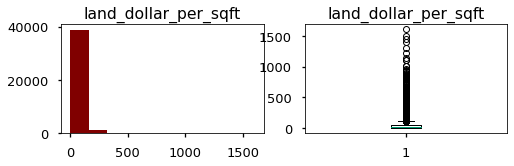

count    40217.000000
mean        41.055693
std         60.780846
min          0.003805
25%          6.341829
50%         25.492223
75%         51.983493
max       1604.525311
Name: land_dollar_per_sqft, dtype: float64


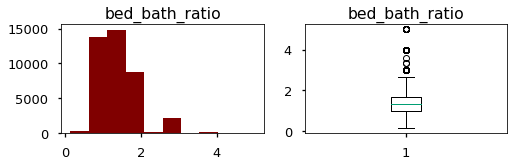

count    40217.000000
mean         1.450311
std          0.565171
min          0.133333
25%          1.000000
50%          1.333333
75%          1.666667
max          5.000000
Name: bed_bath_ratio, dtype: float64


In [24]:
cat_vars = []
quant_vars = ['fips', 'latitude', 'longitude', 'sqft',
       'lot_sqft', 'zip_code', 'property_quality', 'home_age', 'logerror','structure_value', 'bedrooms' , 'bathrooms' , 'land_value','structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio']

explore_univariate(train, cat_vars, quant_vars)

# We insert takeaways !!! 

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

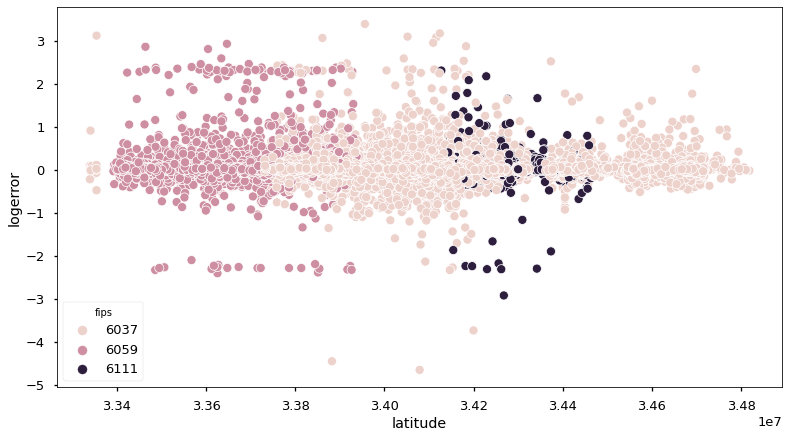

In [25]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='fips')

<AxesSubplot:xlabel='longitude', ylabel='logerror'>

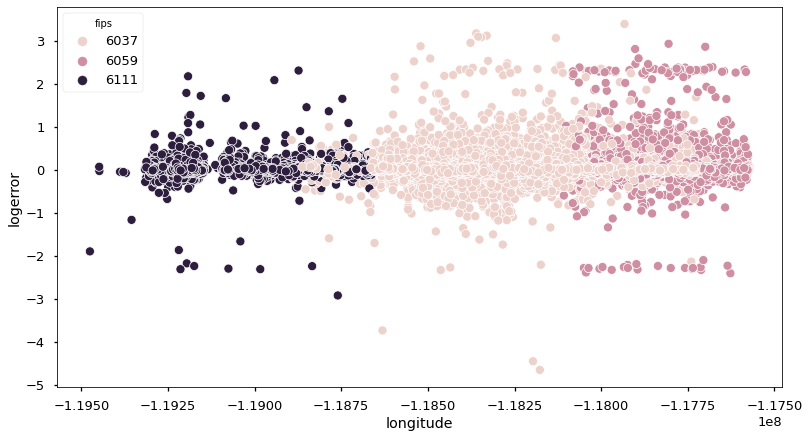

In [26]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='longitude', y='logerror', hue='fips')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

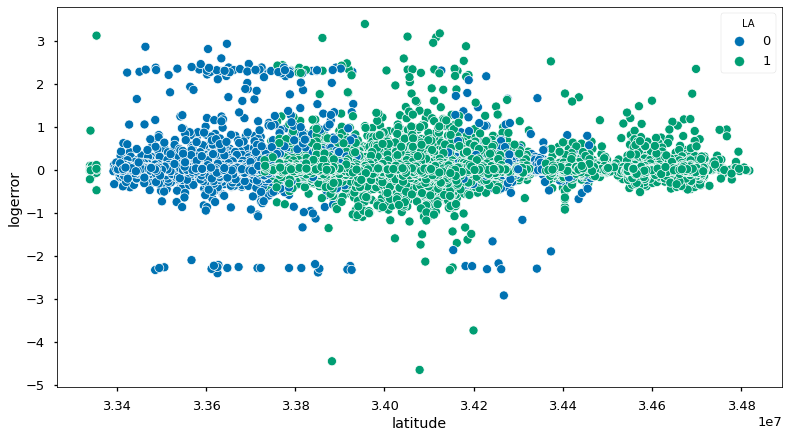

In [27]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='LA')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

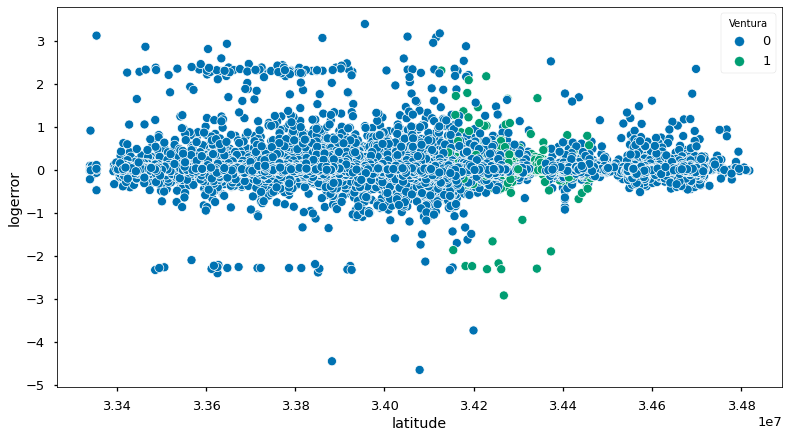

In [28]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='Ventura')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

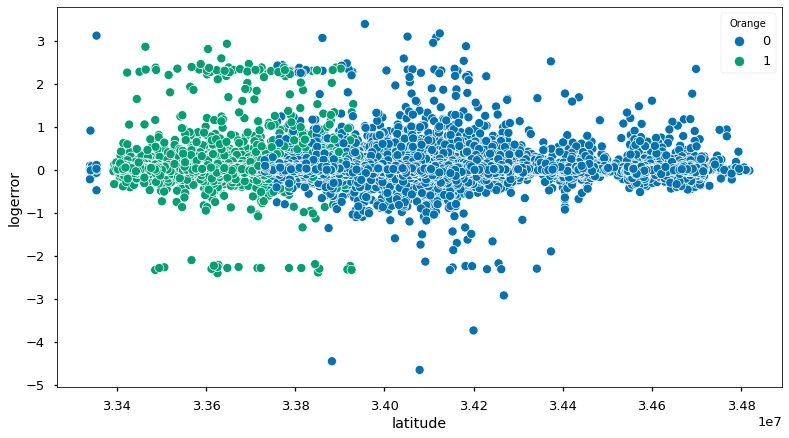

In [29]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='Orange')

<AxesSubplot:xlabel='property_quality', ylabel='logerror'>

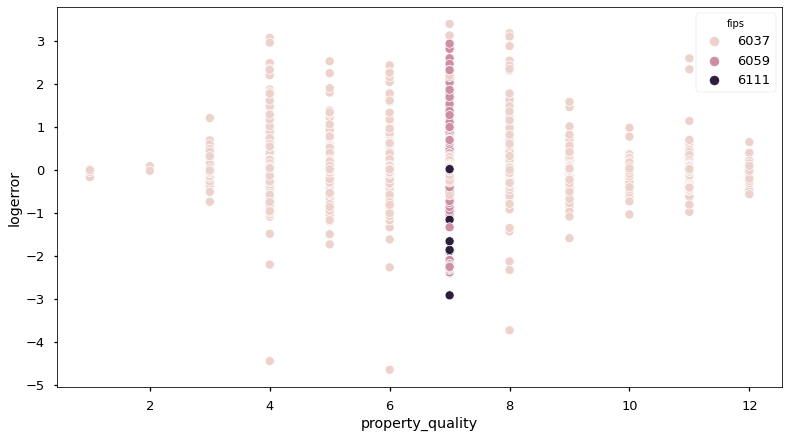

In [30]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='property_quality', y='logerror', hue='fips')

<AxesSubplot:xlabel='home_age', ylabel='fips'>

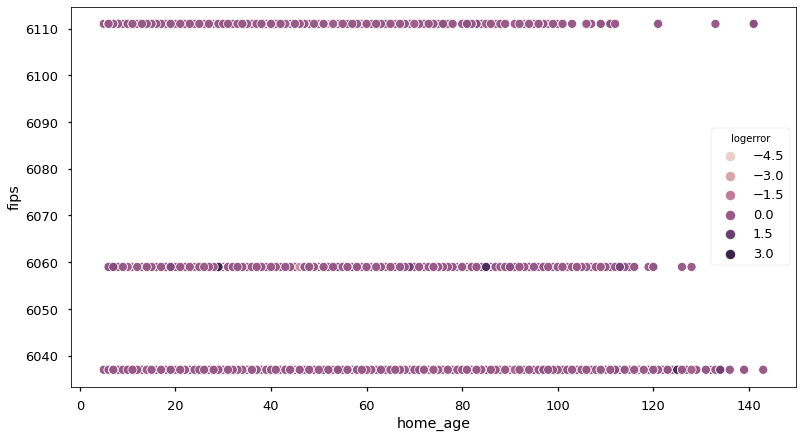

In [31]:
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='home_age', y='fips', hue='logerror')

In [32]:
train.shape, validate.shape, test.shape

((40217, 19), (17237, 16), (14364, 16))

## Hypothises testing 
* Is logerror diffrent in each county 
* Properties of LA vs Orange 
* Properties of LA vs Ventura 
* Properties of Orange vs Ventura 

In [33]:
def correlation_test(nullh, alth, x, y):
    '''
    correlation_test will take in two arguments and 
    - plot a scatterplot of them
    - test the correlation
    return: the correlation coefficient, p, and if there is a linear relationship.
    '''
    
    splot = plt.scatter(x, y, cmap = 'Purples', c='maroon' )
    
    null_hypothesis = nullh
    alternative_hypothesis = alth
    
    confidence_level = .95
    a = 1 - confidence_level 
    
    corr, p = stats.pearsonr(x, y)

    if p < a:
        print(f"Reject null statment: {null_hypothesis}")
        print("There is a linear relationship.")
        if 0 < corr < .6:
            print("Although, it is a positive weak one.")
        elif .6 < corr < 1:
            print("That is a stronger positive correlation.")
        elif -.6 < corr < 0:
            print("Although, it is a negative weak one.")
        elif -1 < corr < -.6:
            print("That is a stronger negative correlation.")
        
    else : 
        print("Fail to reject the null hypothesis.")
        
    print(f"""
    Correlation Coefficient: {corr}
    p: {p}
    
    """)
    return splot

In [34]:
#assign your null hypothesis
nullh = "No correlation between home_age and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between home_age and logerror."

#the feature you are testing
x1 = X_train_scaled.home_age

#against your target
y1 = y_train

Fail to reject the null hypothesis.

    Correlation Coefficient: -0.009091686955585479
    p: 0.06826644862171057
    
    


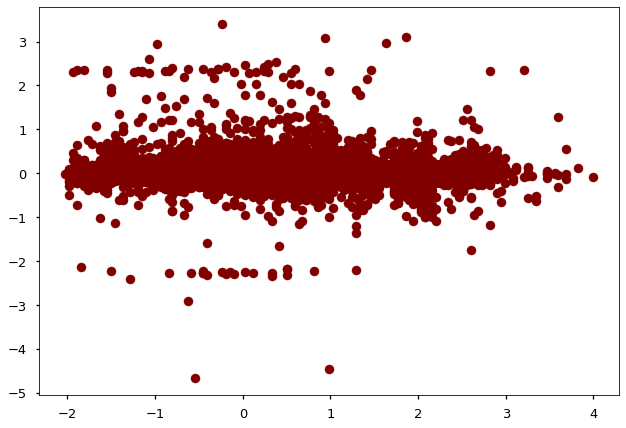

In [35]:
correlation_test(nullh, alth, x1, y1)

In [36]:
#assign your null hypothesis
nullh = "No correlation between lot_sqft and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between lot_sqft and logerror."

#the feature you are testing
x2 = X_train_scaled.lot_sqft

#against your target
y2 = y_train

Reject null statment: No correlation between lot_sqft and logerror.
There is a linear relationship.
Although, it is a positive weak one.

    Correlation Coefficient: 0.012872169213528831
    p: 0.009839073124819048
    
    


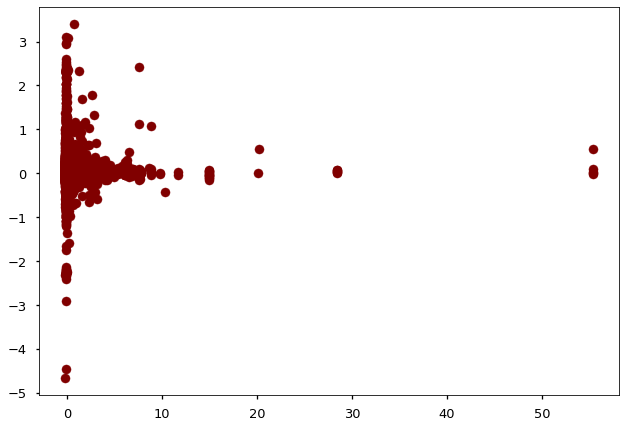

In [37]:
correlation_test(nullh, alth, x2, y2)

In [38]:
#assign your null hypothesis
nullh = "No correlation between land_value and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between land_value and logerror."

#the feature you are testing
x3 = X_train_scaled.land_value

#against your target
y3 = y_train

Fail to reject the null hypothesis.

    Correlation Coefficient: -0.002359023235530234
    p: 0.6361642093651477
    
    


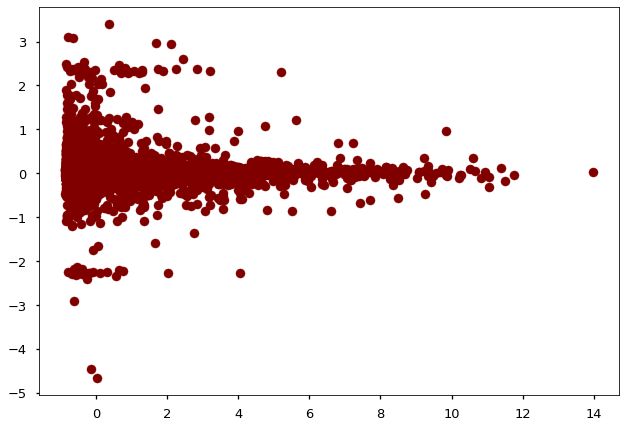

In [39]:
correlation_test(nullh, alth, x3, y3)

In [40]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40217 entries, 11736858 to 14709728
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LA                40217 non-null  float64
 1   Orange            40217 non-null  float64
 2   Ventura           40217 non-null  float64
 3   fips              40217 non-null  float64
 4   latitude          40217 non-null  float64
 5   longitude         40217 non-null  float64
 6   sqft              40217 non-null  float64
 7   lot_sqft          40217 non-null  float64
 8   zip_code          40217 non-null  float64
 9   property_quality  40217 non-null  float64
 10  home_age          40217 non-null  float64
 11  structure_value   40217 non-null  float64
 12  bedrooms          40217 non-null  float64
 13  bathrooms         40217 non-null  float64
 14  land_value        40217 non-null  float64
dtypes: float64(15)
memory usage: 4.9 MB


In [41]:
#set confidence interval and alpha before the test
conf_interval = .95 # desired confidence interval
alpha = 1 - conf_interval

In [42]:
LA = train[train.LA == 1].logerror
Orange = train[train.Orange == 1].logerror
Ventura = train[train.Ventura == 1].logerror

In [43]:
mean_log_la = LA.mean()
mean_log_orange = Orange.mean()
mean_log_ventura = Ventura.mean()

### What is the avrage logerror per county

In [44]:
print('LA: ', mean_log_la)
print('Orange: ', mean_log_orange)
print('Ventura:', mean_log_ventura)

LA:  0.014516765820273388
Orange:  0.01786707488534417
Ventura: 0.013923148212340804


In [45]:
#correlation test summary
def stat_summary(p):
    if p < alpha:
        print(f'Pvalue is: {p} is less than alpha: {alpha}')
        print("Reject the null hypothesis because there is a significant difference present")
    else:
        print(f'Pvalue is: {p} is greater than alpha: {alpha}')
        print("We fail to reject the null hypothesis because there is no significant difference present")

In [46]:
t, p = stats.ttest_ind(LA, Orange, equal_var=False)

## Logerror vs LA and Ventura County 

In [47]:
t, p

(-1.7031191104734367, 0.08856271829227355)

In [48]:
stat_summary(p)

Pvalue is: 0.08856271829227355 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


In [49]:
t, p = stats.ttest_ind(LA, Ventura, equal_var=False)
t,p

(0.20602286996960875, 0.8367828703309689)

In [50]:
stat_summary(p)

Pvalue is: 0.8367828703309689 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


## Logerror vs Orange and Ventura County

In [51]:
t, p = stats.ttest_ind(Orange, Ventura, equal_var=False)
t,p

(1.2275702335554781, 0.21965415832601334)

In [52]:
stat_summary(p)

Pvalue is: 0.21965415832601334 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40217 entries, 11736858 to 14709728
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LA                         40217 non-null  uint8  
 1   Orange                     40217 non-null  uint8  
 2   Ventura                    40217 non-null  uint8  
 3   fips                       40217 non-null  int64  
 4   latitude                   40217 non-null  float64
 5   longitude                  40217 non-null  float64
 6   sqft                       40217 non-null  float64
 7   lot_sqft                   40217 non-null  float64
 8   zip_code                   40217 non-null  int64  
 9   property_quality           40217 non-null  int64  
 10  home_age                   40217 non-null  int64  
 11  logerror                   40217 non-null  float64
 12  structure_value            40217 non-null  float64
 13  bedrooms                   40217 non

## All three counties fail to reject becuase there is no significant difference present 

In [54]:
X = df[['home_age', 'sqft']]

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

k = 2

kmeans = KMeans(n_clusters= k)
kmeans.fit(X_scaled)
kmeans.inertia_

89341.4436593083

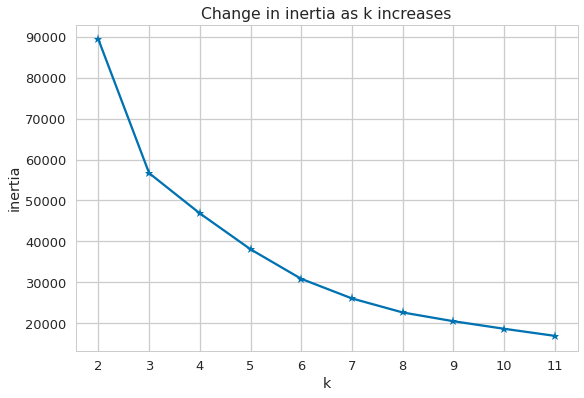

In [55]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='*')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [56]:
X = df[['home_age', 'sqft' ]]
X.head(2)

,home_age,sqft
parcelid,,
14297519,23,3100.0
17052889,54,1465.0


In [57]:
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [58]:
#define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)

array([2, 3, 3, ..., 3, 0, 0], dtype=int32)

In [59]:
X_scaled['cluster'] = kmeans.predict(X_scaled)

In [60]:
X_scaled.head(2)

,home_age,sqft,cluster
14297519,-1.241301,1.555025,2
17052889,0.112154,-0.317152,3


In [61]:
kmeans.cluster_centers_

array([[ 1.0960343 , -0.51973266],
       [-1.25199607,  0.32218325],
       [-0.96066551,  2.73141531],
       [-0.36552532, -0.58155838],
       [ 0.322006  ,  0.69602214]])

In [62]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
centroids_scaled

,home_age,sqft
0,1.096034,-0.519733
1,-1.251996,0.322183
2,-0.960666,2.731415
3,-0.365525,-0.581558
4,0.322006,0.696022


In [63]:
centroids_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   home_age  5 non-null      float64
 1   sqft      5 non-null      float64
dtypes: float64(2)
memory usage: 208.0 bytes


Text(0.5, 1.0, 'Visualizing Cluster Centers K = 5')

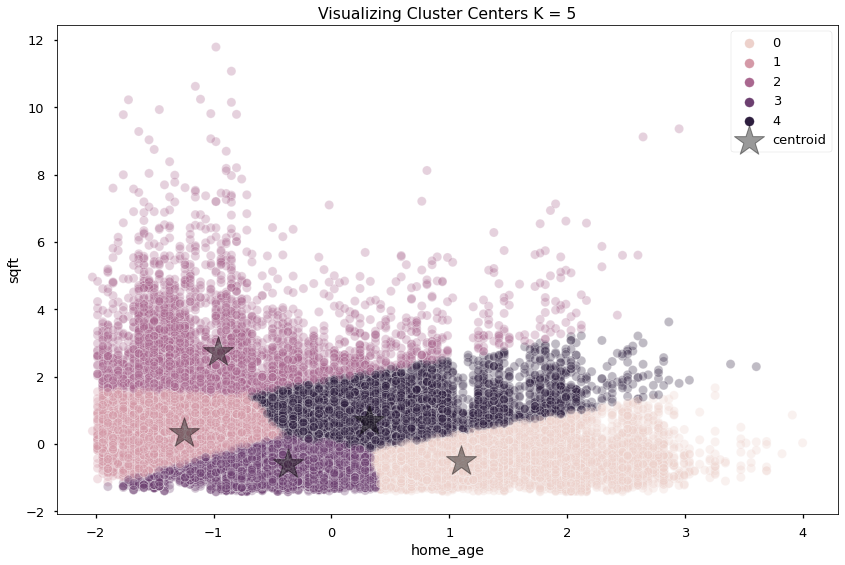

In [64]:
plt.figure(figsize=(14, 9))
sns.scatterplot(x='home_age', y = 'sqft', data = X_scaled,  hue = 'cluster' ,    alpha = 0.3 )
centroids_scaled.plot.scatter(y='sqft', x='home_age', c='k', marker='*', s=1000, ax=plt.gca(), alpha = 0.4, label='centroid', lw = 1)

plt.legend()

plt.title('Visualizing Cluster Centers K = 5')

In [65]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 14297519 to 12826780
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   home_age  71818 non-null  int64  
 1   sqft      71818 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.6 MB


## Property Quality and Home Age

In [66]:
X = df[['property_quality', 'home_age']]

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled2 = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

k = 4

kmeans = KMeans(n_clusters= k)
kmeans.fit(X_scaled)
kmeans.inertia_

59815.8348525461

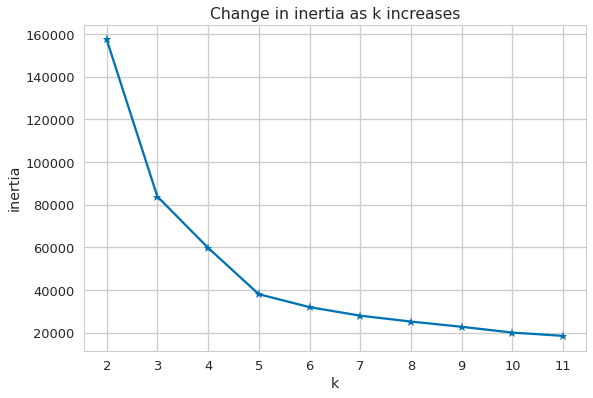

In [67]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='*')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [68]:
X = df[['property_quality', 'home_age']]
X.head(2)

,property_quality,home_age
parcelid,,
14297519,7,23
17052889,7,54


In [69]:
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled2 = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [70]:
#define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X_scaled2)

# Use (predict using) the thing 
kmeans.predict(X_scaled2)

array([1, 2, 2, ..., 2, 0, 3], dtype=int32)

In [71]:
df['pqha_cluster'] = kmeans.predict(X_scaled2)
X_scaled2['pqha_cluster'] = kmeans.predict(X_scaled2)

In [72]:
kmeans.cluster_centers_

array([[-1.94429349,  1.25035872],
       [ 0.2802234 , -1.09164767],
       [ 0.39241996,  0.01119136],
       [-0.25447851,  0.97330779],
       [ 2.22299772, -0.77449804]])

In [73]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
centroids_scaled

,property_quality,home_age
0,-1.944293,1.250359
1,0.280223,-1.091648
2,0.392420,0.011191
3,-0.254479,0.973308
4,2.222998,-0.774498


Text(0.5, 1.0, 'Visualizing Cluster Centers K = 5')

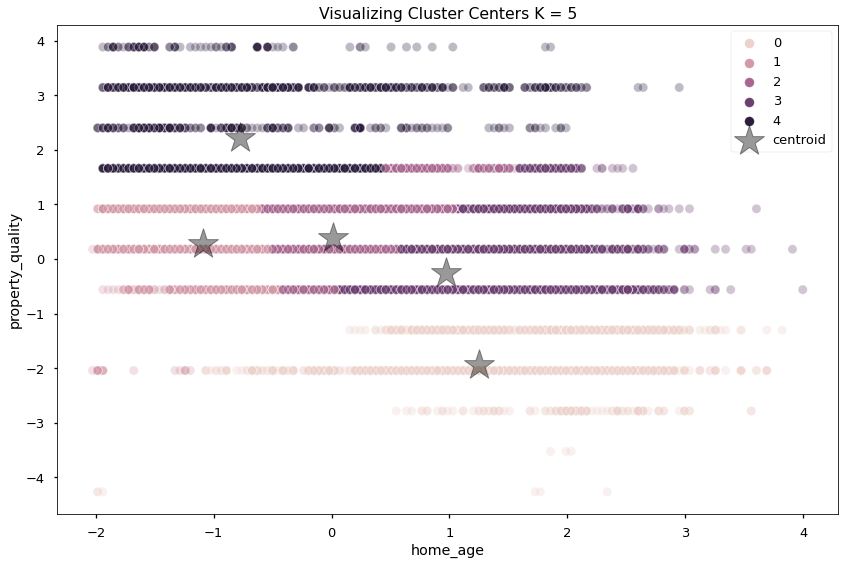

In [74]:
plt.figure(figsize=(14, 9))
sns.scatterplot(x='home_age', y = 'property_quality', data = X_scaled2, hue = 'pqha_cluster',  alpha = 0.3 )
centroids_scaled.plot.scatter(y='property_quality', x='home_age', color ='k', marker='*', s=1000, ax=plt.gca(), alpha = 0.4, label='centroid', lw = 1)

plt.legend()

plt.title('Visualizing Cluster Centers K = 5')

## I will Encode the Features 

In [75]:
X_scaled2.head()

,property_quality,home_age,pqha_cluster
14297519,0.178913,-1.241301,1
17052889,0.178913,0.112154,2
14186244,0.178913,0.330453,2
12177905,0.919541,-0.018826,2
10887214,0.919541,0.243134,2


In [76]:
cluster_df = pd.concat([X_scaled, X_scaled2], axis= 1)

In [77]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 14297519 to 12826780
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   home_age          71818 non-null  float64
 1   sqft              71818 non-null  float64
 2   cluster           71818 non-null  int32  
 3   property_quality  71818 non-null  float64
 4   home_age          71818 non-null  float64
 5   pqha_cluster      71818 non-null  int32  
dtypes: float64(4), int32(2)
memory usage: 3.3 MB


In [78]:
cluster_df.shape

(71818, 6)

In [79]:
cluster_df = pd.concat([new, cluster_df], axis= 1)

In [80]:
cluster_df.shape

(71818, 25)

In [81]:
cluster_dummies = pd.get_dummies(cluster_df.cluster, prefix='homeagexquality')

In [82]:
cluster_dummies

,homeagexquality_0,homeagexquality_1,homeagexquality_2,homeagexquality_3,homeagexquality_4
14297519,0,0,1,0,0
17052889,0,0,0,1,0
14186244,0,0,0,1,0
12177905,0,0,0,0,1
10887214,0,0,0,1,0
...,...,...,...,...,...
10833991,0,0,0,1,0
11000655,1,0,0,0,0
17239384,0,0,0,1,0
12773139,1,0,0,0,0


In [83]:
cluster_dummies.rename(columns={"homeagexquality_cluster_0": "avgqualityavgage", "homeagexquality_cluster_1": "poor_quality_old_age", "homeagexquality_cluster_2": "avq_quality_young_age", "homeagexquality_cluster_3": "avg_quality_old_age", "homeagexquality_cluster_4": "bestest"})

,homeagexquality_0,homeagexquality_1,homeagexquality_2,homeagexquality_3,homeagexquality_4
14297519,0,0,1,0,0
17052889,0,0,0,1,0
14186244,0,0,0,1,0
12177905,0,0,0,0,1
10887214,0,0,0,1,0
...,...,...,...,...,...
10833991,0,0,0,1,0
11000655,1,0,0,0,0
17239384,0,0,0,1,0
12773139,1,0,0,0,0


In [84]:
cluster_dummies

,homeagexquality_0,homeagexquality_1,homeagexquality_2,homeagexquality_3,homeagexquality_4
14297519,0,0,1,0,0
17052889,0,0,0,1,0
14186244,0,0,0,1,0
12177905,0,0,0,0,1
10887214,0,0,0,1,0
...,...,...,...,...,...
10833991,0,0,0,1,0
11000655,1,0,0,0,0
17239384,0,0,0,1,0
12773139,1,0,0,0,0


In [85]:
df1 = pd.concat([cluster_df, cluster_dummies], axis=1)

In [86]:
df1.head()

,LA,Orange,Ventura,fips,latitude,longitude,sqft,lot_sqft,zip_code,property_quality,...,sqft,cluster,property_quality,home_age,pqha_cluster,homeagexquality_0,homeagexquality_1,homeagexquality_2,homeagexquality_3,homeagexquality_4
14297519,0,1,0,6059,33634931.0,-117869207.0,3100.0,4506.0,96978,7,...,1.555025,2,0.178913,-1.241301,1,0,0,1,0,0
17052889,0,0,1,6111,34449266.0,-119281531.0,1465.0,12647.0,97099,7,...,-0.317152,3,0.178913,0.112154,2,0,0,0,1,0
14186244,0,1,0,6059,33886168.0,-117823170.0,1243.0,8432.0,97078,7,...,-0.571356,3,0.178913,0.330453,2,0,0,0,1,0
12177905,1,0,0,6037,34245180.0,-118240722.0,2376.0,13038.0,96330,8,...,0.726000,4,0.919541,-0.018826,2,0,0,0,0,1
10887214,1,0,0,6037,34185120.0,-118414640.0,1312.0,278581.0,96451,8,...,-0.492347,3,0.919541,0.243134,2,0,0,0,1,0


In [87]:
df1.rename(columns={"homeagexquality_0": "avgqualityavgage", "homeagexquality_1": "poor_quality_old_age", "homeagexquality_2": "avq_quality_young_age", "homeagexquality_3": "avg_quality_old_age", "homeagexquality_4": "bestest"})

,LA,Orange,Ventura,fips,latitude,longitude,sqft,lot_sqft,zip_code,property_quality,...,sqft,cluster,property_quality,home_age,pqha_cluster,avgqualityavgage,poor_quality_old_age,avq_quality_young_age,avg_quality_old_age,bestest
14297519,0,1,0,6059,33634931.0,-117869207.0,3100.0,4506.0,96978,7,...,1.555025,2,0.178913,-1.241301,1,0,0,1,0,0
17052889,0,0,1,6111,34449266.0,-119281531.0,1465.0,12647.0,97099,7,...,-0.317152,3,0.178913,0.112154,2,0,0,0,1,0
14186244,0,1,0,6059,33886168.0,-117823170.0,1243.0,8432.0,97078,7,...,-0.571356,3,0.178913,0.330453,2,0,0,0,1,0
12177905,1,0,0,6037,34245180.0,-118240722.0,2376.0,13038.0,96330,8,...,0.726000,4,0.919541,-0.018826,2,0,0,0,0,1
10887214,1,0,0,6037,34185120.0,-118414640.0,1312.0,278581.0,96451,8,...,-0.492347,3,0.919541,0.243134,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833991,1,0,0,6037,34202400.0,-118502000.0,1741.0,59487.0,96415,8,...,-0.001115,3,0.919541,-0.455424,2,0,0,0,1,0
11000655,1,0,0,6037,34245368.0,-118282383.0,1286.0,47405.0,96284,6,...,-0.522118,0,-0.561716,1.290970,3,1,0,0,0,0
17239384,0,0,1,6111,34300140.0,-118706327.0,1612.0,12105.0,97116,7,...,-0.148828,3,0.178913,0.243134,2,0,0,0,1,0
12773139,1,0,0,6037,34040895.0,-118038169.0,1032.0,5074.0,96480,4,...,-0.812964,0,-2.042972,0.679732,0,1,0,0,0,0


In [88]:
df = df1

In [89]:
df = df.drop(['cluster', 'pqha_cluster'], axis=1)

In [90]:
df = df.rename(columns={"homeagexquality_0": "avgqualityavgage", "homeagexquality_1": "poor_quality_old_age", "homeagexquality_2": "avq_quality_young_age", "homeagexquality_3": "avg_quality_old_age", "homeagexquality_4": "bestest"})

In [91]:
df.head()

,LA,Orange,Ventura,fips,latitude,longitude,sqft,lot_sqft,zip_code,property_quality,...,bed_bath_ratio,home_age,sqft,property_quality,home_age,avgqualityavgage,poor_quality_old_age,avq_quality_young_age,avg_quality_old_age,bestest
14297519,0,1,0,6059,33634931.0,-117869207.0,3100.0,4506.0,96978,7,...,1.142857,-1.241301,1.555025,0.178913,-1.241301,0,0,1,0,0
17052889,0,0,1,6111,34449266.0,-119281531.0,1465.0,12647.0,97099,7,...,2.000000,0.112154,-0.317152,0.178913,0.112154,0,0,0,1,0
14186244,0,1,0,6059,33886168.0,-117823170.0,1243.0,8432.0,97078,7,...,1.500000,0.330453,-0.571356,0.178913,0.330453,0,0,0,1,0
12177905,1,0,0,6037,34245180.0,-118240722.0,2376.0,13038.0,96330,8,...,1.333333,-0.018826,0.726000,0.919541,-0.018826,0,0,0,0,1
10887214,1,0,0,6037,34185120.0,-118414640.0,1312.0,278581.0,96451,8,...,1.000000,0.243134,-0.492347,0.919541,0.243134,0,0,0,1,0


## Evaluation of the Data 

In [92]:
object_cols = w.get_object_cols(df)
object_cols

[]

In [93]:
df.columns.to_list()

['LA',
 'Orange',
 'Ventura',
 'fips',
 'latitude',
 'longitude',
 'sqft',
 'lot_sqft',
 'zip_code',
 'property_quality',
 'home_age',
 'logerror',
 'structure_value',
 'bedrooms',
 'bathrooms',
 'land_value',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'bed_bath_ratio',
 'home_age',
 'sqft',
 'property_quality',
 'home_age',
 'avgqualityavgage',
 'poor_quality_old_age',
 'avq_quality_young_age',
 'avg_quality_old_age',
 'bestest']

In [94]:
numeric_cols = ['LA',
 'Orange',
 'Ventura',
 'fips',
 'latitude',
 'longitude',
 'sqft',
 'lot_sqft',
 'zip_code',
 'property_quality',
 'home_age',
 'logerror',
 'structure_value',
 'bedrooms',
 'bathrooms',
 'land_value',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'bed_bath_ratio',
 'home_age',
 'sqft',
 'property_quality',
 'home_age',
 'avgqualityavgage',
 'poor_quality_old_age',
 'avq_quality_young_age',
 'avg_quality_old_age',
 'bestest']

In [95]:
X_train, y_train, X_validate, y_validate, X_test, y_test = w.train_validate_test_split(df, "logerror", 6543)

In [96]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Standard_Scaler(X_train, X_validate, X_test)

In [97]:
X_train_scaled.head(2).T

,14168996,12518411
LA,-1.339262,0.746680
Orange,1.627918,-0.614281
Ventura,-0.302814,-0.302814
fips,0.463754,-0.581892
latitude,-0.432889,-0.796852
longitude,0.958932,0.276494
sqft,0.265717,-0.444245
lot_sqft,-0.180295,-0.193295
zip_code,0.105756,-0.085415
property_quality,0.178282,-0.561194


## Feature engineering 
* We have added new encoded features and we will be testing out of top ten to see if any of our choices made it 

In [101]:
def select_kbest(X, y, n):
    '''
    select_kbest takes in the 
    predictors (X), 
    the target (y), and 
    the number of features to select (k) and 
    returns the names of the top k selected features based on the SelectKBest class
    '''
    
    # parameters: f_regression stats test
    f_selector = SelectKBest(f_regression, k= n)
    
    # find the top 2 X-feats correlated with y
    f_selector.fit(X, y)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    # get list of top K features. 
    f_feature = X.iloc[:,feature_mask].columns.tolist()
    
    return f_feature

In [ ]:
f_selector = SelectKBest(f_regression, k=10)
f_selector.fit(X_train_scaled, y)
feature_mask = f_selector.get_support()
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [102]:
def rfe(X, y, n):
    '''
    rfe takes in the 
    predictors (X), 
    the target (y), and 
    the number of features to select (k) and 
    returns the names of the top k selected features based on the SelectKBest class
    '''
    
    # initialize the ML algorithm
    lm = LinearRegression()
    
    # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
    rfe = RFE(lm, n)
    
    # fit the data using RFE
    rfe.fit(X,y)  
    
    # get the mask of the columns selected
    feature_mask = rfe.support_
    
    # get list of the column names. 
    rfe_feature = X.iloc[:,feature_mask].columns.tolist()
    
    return rfe_feature



In [106]:
select_kbest(X_train_scaled, y_train, 10)

['longitude',
 'sqft',
 'lot_sqft',
 'bedrooms',
 'bathrooms',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'sqft',
 'avq_quality_young_age',
 'avg_quality_old_age']

# So this is very interesting, 2 of our encoded values made the list 

<img src="modeling.tif"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 20px;" />

In [109]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [110]:
y_train.head()

,logerror
14168996,0.009161
12518411,0.027330
14602445,-0.003372
17154690,-0.009766
11858352,0.304762


## We are now going to see what our baseline is 

In [111]:
# 1. compute pred_median
logerror_baseline_median = y_train['logerror'].median()
y_train['logerror_baseline_median'] = logerror_baseline_median
y_validate['logerror_baseline_median'] = logerror_baseline_median

# 2. compute pred_mean
logerror_baseline_mean = y_train['logerror'].mean()
y_train['logerror_baseline_mean'] = logerror_baseline_mean
y_validate['logerror_baseline_mean'] = logerror_baseline_mean

#check to see which is better
y_train.head()

,logerror,logerror_baseline_median,logerror_baseline_mean
14168996,0.009161,0.006644,0.015529
12518411,0.027330,0.006644,0.015529
14602445,-0.003372,0.006644,0.015529
17154690,-0.009766,0.006644,0.015529
11858352,0.304762,0.006644,0.015529


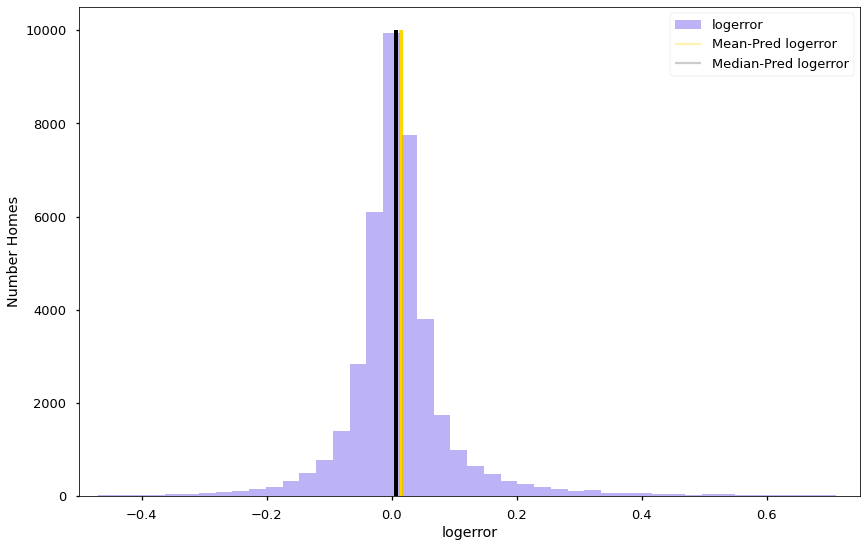

In [112]:
plt.figure(figsize=(14, 9))
plt.hist(y_train.logerror, color='mediumslateblue', bins=300, alpha=.5, label="logerror")
plt.vlines(y_train.logerror_baseline_mean, 0, 10000, color='gold', alpha=.3, label="Mean-Pred logerror")
plt.vlines(y_train.logerror_baseline_median, 0, 10000, color='black', alpha=.2, label="Median-Pred logerror")
plt.xlim(-0.5, 0.75)
plt.xlabel("logerror")
plt.ylabel("Number Homes")
plt.legend()
plt.show()

# I will push for the median Prediction becuase it is performing better 

In [113]:
# RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_baseline_median) ** (0.5)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_baseline_median) ** (0.5)

print(f"""
      BASELINE:
      RMSE using Median
      Train/In-Sample: {round(rmse_train, 6)}
      Validate/Out-of-Sample: {round(rmse_validate, 6)}
        """)


      BASELINE:
      RMSE using Median
      Train/In-Sample: 0.164122
      Validate/Out-of-Sample: 0.166928
        


# TRAIN AND VALIDATION 

# LinearRegression (OLS)

In [114]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(0.5)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: {round(rmse_train_lm, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: 0.163524
    Validation/Out-of-Sample: 0.166435



# LassoLars

In [115]:
# create the model object
# I will leave α as the defaulted 1 for now
# since DF has a small amt of features.
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(0.5)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

    RMSE for LassoLars
    
    Training/In-Sample: {round(rmse_train_lars, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.163524
                Validation/Out-of-Sample: 0.166435

    RMSE for LassoLars
    
    Training/In-Sample: 0.163881
    Validation/Out-of-Sample: 0.166614



# PolynomialFeatures

In [116]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [117]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(0.5)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}

                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: {round(rmse_train_lm2, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lm2, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.163524
                Validation/Out-of-Sample: 0.166435

                RMSE for LassoLars
                
                Training/In-Sample: 0.163881
                Validation/Out-of-Sample: 0.166614

                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: 0.162752
    Validation/Out-of-Sample: 0.230653



# Cubic Function

In [118]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf3.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf3.transform(X_validate_scaled)
X_test_degree3 = pf3.transform(X_test_scaled)

In [119]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.logerror)

# predict train
y_train['logerror_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train_lm3 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3)**(0.5)

# predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_lm3 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3)**(0.5)

print(f"""
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 6)}
Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
RMSE for OLS using LinearRegression
                
Training/In-Sample: {round(rmse_train_lm, 6)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

RMSE for LassoLars
                
Training/In-Sample: {round(rmse_train_lars, 6)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}

RMSE for Polynomial Regressor degrees=2
        
Training/In-Sample: {round(rmse_train_lm2, 6)}
Validation/Out-of-Sample: {round(rmse_validate_lm2, 6)}
                
RMSE for Polynomial Regressor degrees=3
    
Training/In-Sample: {round(rmse_train_lm3, 6)}
Validation/Out-of-Sample: {round(rmse_validate_lm3, 6)}              
""")


BASELINE:
              
RMSE using Median
Train/In-Sample: 0.164122
Validate/Out-of-Sample: 0.166928
              
RMSE for OLS using LinearRegression
                
Training/In-Sample: 0.163524
Validation/Out-of-Sample: 0.166435

RMSE for LassoLars
                
Training/In-Sample: 0.163881
Validation/Out-of-Sample: 0.166614

RMSE for Polynomial Regressor degrees=2
        
Training/In-Sample: 0.162752
Validation/Out-of-Sample: 0.230653
                
RMSE for Polynomial Regressor degrees=3
    
Training/In-Sample: 0.158873
Validation/Out-of-Sample: 221.800305              



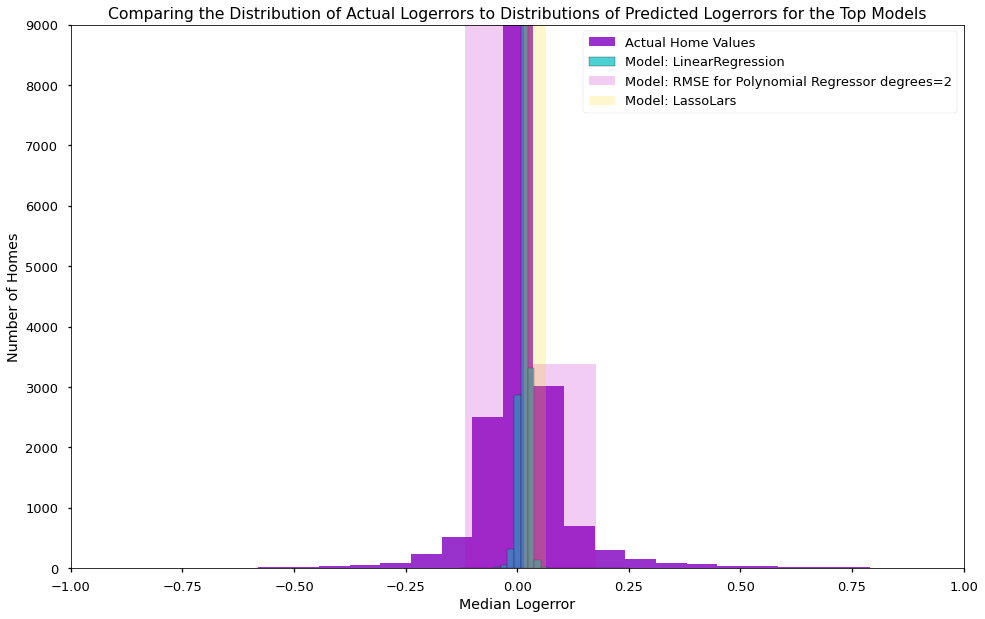

In [124]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.logerror, color='darkorchid', alpha=1, bins=100, label="Actual Home Values")
plt.hist(y_validate.logerror_pred_lm, color='c', alpha=.7, bins=25, label="Model: LinearRegression", ec='black')
#plt.hist(y_validate.logerror_pred_lm3, color='chartreuse', alpha=.2, bins=200, label="Model: RMSE for Polynomial Regressor degrees=3")
plt.hist(y_validate.logerror_pred_lm2, color='m', alpha=.2, bins=200, label="Model: RMSE for Polynomial Regressor degrees=2")
plt.hist(y_validate.logerror_pred_lars, color='gold', alpha=.2, bins=20, label="Model: LassoLars")

plt.xlim(-1, 1)
plt.ylim(0, 9000)
plt.xlabel("Median Logerror")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Logerrors to Distributions of Predicted Logerrors for the Top Models")
plt.legend()
plt.show()

In [125]:
y_test = pd.DataFrame(y_test)

#predict on test
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
              
    RMSE for OLS using LinearRegression
    
    Test/Out-of-Sample Performance: {round(rmse_test, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928
              
              
    RMSE for OLS using LinearRegression
    
    Test/Out-of-Sample Performance: 0.161763



## Conclusion // Summary -- 